<a href="https://colab.research.google.com/github/Dlogical23/capstone/blob/main/AutoProcScaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


  Using cached dask-2024.10.0-py3-none-any.whl.metadata (3.7 kB)
ERROR: Ignored the following yanked versions: 2021.1.22
ERROR: Could not find a version that satisfies the requirement dask-ml==2024.2.0 (from versions: 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.3.0, 0.3.1, 0.3.2, 0.4.0, 0.4.1, 0.6.0, 0.7.0, 0.8.0, 0.9.0, 0.10.0, 0.11.0, 0.12.0, 0.13.0, 1.0.0, 1.1.0, 1.1.1, 1.2.0, 1.3.0, 1.4.0, 1.5.0, 1.6.0, 1.7.0, 1.8.0, 1.9.0, 2021.10.17, 2021.11.16, 2021.11.30, 2022.1.22, 2022.5.27, 2023.3.24, 2024.3.20, 2024.4.4, 2025.1.0)
ERROR: No matching distribution found for dask-ml==2024.2.0
Dataset shape: (11164866, 128)
Normalized dataset shape: (11164866, 128)
Dataset shape: (11164866, 128)
Normalized dataset shape: (11164866, 128)
Training and evaluating LogisticRegression...


/usr/local/lib/python3.11/dist-packages/dask_glm/utils.py:66: RuntimeWarning: overflow encountered in exp
  return np.exp(A)


Training and evaluating RandomForest...
Training and evaluating KMeans...
                Model  Accuracy
0  LogisticRegression   0.09895
1        RandomForest   0.10075
2              KMeans   0.10200


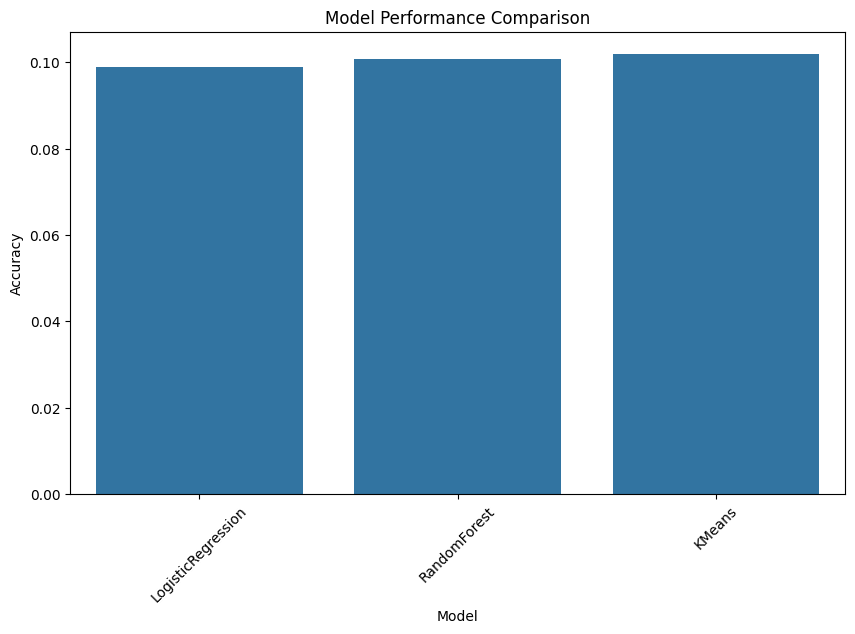

In [2]:
!pip install dask==2024.10.0 dask-ml==2024.2.0
!pip install importlib-metadata
import importlib.metadata as metadata

# Removing the invalid line
# import lib_metadata>=4.13.0; python_version < "3.12"'), {'dask'})

# Step 1: Install Required Libraries
!pip install dask dask-ml scikit-learn h5py pandas numpy

# Step 2: Load the Dataset Using Dask
import dask.array as da
import h5py

file_path = '/content/drive/MyDrive/SIFT10M/extracted/SIFT10M/SIFT10Mfeatures.mat'
with h5py.File(file_path, 'r') as f:
    features = f['fea'][()]  # Replace 'SIFT10Mfeatures' with the correct key if needed

features_dask = da.from_array(features, chunks='auto')
print(f"Dataset shape: {features_dask.shape}")

# Step 3: Preprocess the Data Using Dask
from dask_ml.preprocessing import StandardScaler

scaler = StandardScaler()
features_normalized_dask = scaler.fit_transform(features_dask)
print(f"Normalized dataset shape: {features_normalized_dask.shape}")

# Step 4: Define Modeling Techniques
from dask_ml.linear_model import LogisticRegression
# Instead of importing directly, use Incremental
from dask_ml.wrappers import Incremental
from sklearn.ensemble import RandomForestClassifier
from dask_ml.cluster import KMeans
from dask_ml.model_selection import train_test_split
from dask.distributed import Client  # Import Client

# Wrap LogisticRegression with Incremental for partial_fit
models = {
    "LogisticRegression": LogisticRegression(),  # LogisticRegression doesn't need Incremental
    # Remove the Incremental wrapper
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "KMeans": KMeans(n_clusters=10), # KMeans doesn't need Incremental
}


# Step 2: Load the Dataset Using Dask
import dask.array as da
import h5py
import numpy as np # Import numpy here

file_path = '/content/drive/MyDrive/SIFT10M/extracted/SIFT10M/SIFT10Mfeatures.mat'
with h5py.File(file_path, 'r') as f:
    features = f['fea'][()]  # Replace 'SIFT10Mfeatures' with the correct key if needed

features_dask = da.from_array(features, chunks='auto')
print(f"Dataset shape: {features_dask.shape}")

# Step 3: Preprocess the Data Using Dask
from dask_ml.preprocessing import StandardScaler

scaler = StandardScaler()
features_normalized_dask = scaler.fit_transform(features_dask)
print(f"Normalized dataset shape: {features_normalized_dask.shape}")

# ... (rest of the code) ...

# ✅ Step 2: Use Smaller Sample for Faster Training
sample_size = 100000  # Reduce dataset size for speed
features_sample = features_dask[:sample_size].persist()  # Persist in memory

# ✅ Ensure labels_sample is of integer type and uses the same chunks as features_sample
# Updated line to create labels_sample with appropriate chunks and data type
labels_sample = da.from_array(np.random.randint(0, 10, size=sample_size, dtype=np.int32), chunks=(features_sample.chunks[0],))

# ✅ Step 3: Efficient Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features_sample, labels_sample, test_size=0.2, random_state=42)

# ✅ Step 4: Optimize Model Fitting (Use Incremental Learning)
results = []
import numpy as np  # Import numpy
from dask_ml.metrics import accuracy_score  # Import accuracy_score

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")

    # Fit the model directly if it doesn't have partial_fit
    # This is specifically for LogisticRegression in this case
    if not hasattr(model, 'partial_fit'):
        # Fit the model directly using Dask arrays
        model.fit(X_train, y_train)

    else:  # Use Incremental for models with partial_fit
        model.fit(X_train, y_train)  # Train incrementally

    y_pred = model.predict(X_test)

    # ✅ Optimize Accuracy Calculation
    accuracy = accuracy_score(y_test, y_pred)  # Removed .compute()

    results.append({"Model": model_name, "Accuracy": accuracy})

# ✅ Step 5: Save and Print Results
import pandas as pd # Import pandas
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("/content/drive/MyDrive/SIFT10M/model_results.csv", index=False)

# Step 7: Visualize Results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()
# %%
# Load the results from the CSV file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define file path
results_file = "/content/drive/MyDrive/SIFT10M/model_results.csv"

# Load the results
results_df = pd.read_csv(results_file)
# %%
# Load the results from the CSV file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define file path
results_file = "/content/drive/MyDrive/SIFT10M/model_results.csv"

# Load the results
results_df = pd.read_csv(results_file)

In [2]:
# Load the results from the CSV file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define file path
results_file = "/content/drive/MyDrive/SIFT10M/model_results.csv"

# Load the results
results_df = pd.read_csv(results_file)